# Design 100 qubits programmatically

#### Prerequisite
A working local installation of Ansys

## N_x by N_y grid of qubits

A simple example of generating a large grid of qubits.

Using TransmonPocket and RouteMeander, we can generate a large, varied grid array of qubits. This is not a practical design given the lack of readouts or control lines to the qubits, just an example for how to make a design algorithmically.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import qiskit_metal as metal
from qiskit_metal import designs, MetalGUI
from qiskit_metal import Dict, Headings

In [3]:
design = designs.DesignPlanar()
gui = MetalGUI(design)

In [4]:
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander

In [5]:
design.overwrite_enabled = True

## Design

We can vary how big we want the grid to be by changing N_x/N_y (number of qubits along the x/y axis).
Be careful as very large arrays can take a fair bit of time to generate. We modify the chip size so it contains all of the qubits.

In [6]:
N_x =4
N_y =3

In [7]:
design.chips.main.size.size_x = str((N_x+1) * 3)+'mm'
design.chips.main.size.size_y = str((N_y+1) * 3)+'mm'

design.chips.main.size.center_x = str((N_x-1) * 1.5)+'mm'
design.chips.main.size.center_y = str((N_y-0.5) * 1.5)+'mm'

First we generate the qubits. We use some simple math to generate the offset pattern in order to make the bus resonators easier to connect.

In [8]:
#Loop to generate and draw the qubits
for x in range(N_x):
    for y in range(N_y):
        options = dict(pos_x= str(x*3000)+'um', pos_y = str(y*3000 + (x%2)*1500)+'um', orientation = "-90",
                      connection_pads = dict(
                            B0 = dict(loc_W=-1, loc_H=-1, pad_width='75um'),
                            B1  = dict(loc_W=-1, loc_H=+1, pad_width='120um'),
                            B2  = dict(loc_W=+1, loc_H=-1, pad_width='120um'),
                            B3 = dict(loc_w = +1, loc_H = +1, pad_width='90um')))

        
        obj=TransmonPocket(design,'Q_'+str(x)+'_'+str(y),options)
        
        
gui.rebuild()
gui.autoscale()

Next, we generate the route meanders. As we used consistent naming schemes for the qubits and pins, we can loop through them with out issue.
We also have the length vary based on which qubit is being connected, such that no qubit should be connected to two resonators of the same frequency.

In [9]:
for x in range(N_x):
    for y in range(N_y):
        #"upward" connection, avoids drawing connectors for 'top' row. Changes connector length by +/-50um to avoid frequency collisions
        if y<(N_y-1):
            connectorAD = RouteMeander(design,'CU_'+str(x)+'_'+str(y),options = dict(total_length = str(7+(y%2)*0.5)+'mm',
                                                                                    fillet = "99um",lead=dict(
                                                                                    start_straight='0.5mm',
                                                                                    end_straight='0.25mm'),
                                                                                    meander = dict(asymmetry='-700um'),
                                                                                    pin_inputs = dict(
                                                                                        start_pin=dict(
                                                                                            component ='Q_'+str(x)+'_'+str(y),
                                                                                            pin = 'B0'), 
                                                                                        end_pin=dict(
                                                                                            component='Q_'+str(x)+'_'+str(y+1),
                                                                                            pin='B3'))))
            
        #"sideways" connection, avoids drawing for far right col, and for top qubit in odd col. Changes connector length by +/- 25um 
        #to avoid frequency collisions
        if x<(N_x-1) and (not(x%2 and y==(N_y-1))):
            connectorBC = RouteMeander(design,'CS_'+str(x)+'_'+str(y),options= dict(total_length = str(6+(y%2)*0.5)+'mm',
                                                                                    fillet = "99um",lead=Dict(
                                                                                        start_straight='0.3mm',
                                                                                        end_straight='0.25mm'),
                                                                                    meander = Dict(asymmetry='-200um'),
                                                                                    pin_inputs = Dict(
                                                                                        start_pin=Dict(
                                                                                            component ='Q_'+str(x)+'_'+str(y),
                                                                                            pin = 'B1'), 
                                                                                        end_pin=Dict(
                                                                                            component='Q_'+str(x+1)+'_'+str(y+(x%2)),
                                                                                             pin='B2'))))
            

gui.rebuild()
gui.autoscale()

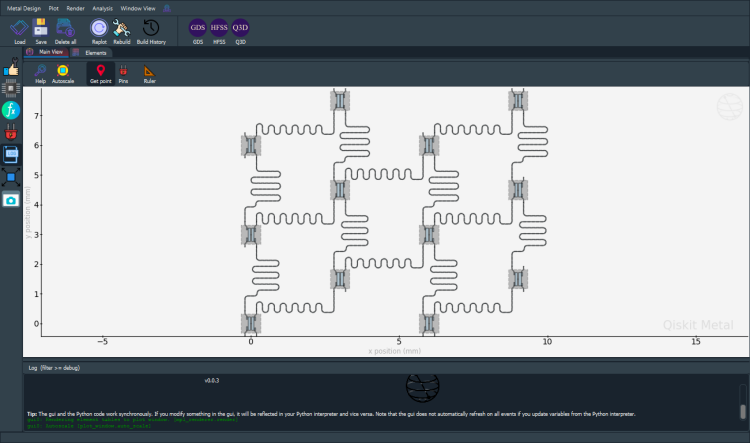

In [10]:
gui.screenshot()

## Analysis

We can quickly check if we have designed the qubits well with an LOM analysis. 
First we render the qubit to Ansys Q3D. Comment the "LOM_q3d.open_ansys()" command if you already have an Ansys session open.

In [11]:
LOM_q3d = design.renderers.q3d

In [12]:
#If you don't already have ansys open: 
LOM_q3d.open_ansys() 

*Make sure Ansys is fully opened and you have dealt with any pop up boxes before proceeding*

In [13]:
# If a project was not automatically opened, you can manually create/open one from the Ansys GUI. 
# Alternatively you can execute the following command.
# LOM_q3d.new_ansys_project()

In [14]:
LOM_q3d.connect_ansys()
LOM_q3d.activate_q3d_design("Qubit_Q3D")
LOM_q3d.add_q3d_setup(name="LOM", max_passes = 14)
LOM_q3d.activate_q3d_setup("LOM")

INFO 09:25AM [connect_project]: Connecting to Ansys Desktop API...
INFO 09:25AM [load_ansys_project]: 	Opened Ansys App
INFO 09:25AM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 09:25AM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Ansoft/
	Project:   Project15
INFO 09:25AM [connect_design]: No active design found (or error getting active design).
INFO 09:25AM [connect]: 	 Connected to project "Project15". No design detected
09:25AM 10s WARNING [activate_q3d_design]: The name=Qubit_Q3D was not in active project.  A new design will be inserted to the project.  Names in active project are: 
[].  
INFO 09:25AM [connect_design]: 	Opened active design
	Design:    Qubit_Q3D [Solution type: Q3D]
WARNING 09:25AM [connect_setup]: 	No design setup detected.
WARNING 09:25AM [connect_setup]: 	Creating Q3D default setup.
INFO 09:25AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:25AM [get_setup]: 	Opened setup `LOM`  (<class 'pyEPR.ansy

We will pick the first qubit, Q_0_0, making sure to apply open terminations to the connection pads. The default bounding box is sufficient for a simple analysis.

In [15]:
LOM_q3d.render_design(['Q_0_0'], [('Q_0_0', 'B0'), ('Q_0_0', 'B1'), ('Q_0_0', 'B2'), ('Q_0_0', 'B3')])

In [16]:
LOM_q3d.analyze_setup("LOM")

INFO 09:25AM [get_setup]: 	Opened setup `LOM`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:25AM [analyze]: Analyzing setup LOM


We then use the results of that simulation to complete a LOM analysis. The input values should be modified based on the simulation passes and the set frequencies of the resonators.

In [17]:
dict_lom = LOM_q3d.lumped_oscillator_vs_passes(12.31, 2, 4, 6.6, [6.0, 6.2,6.4], 9)

INFO 09:26AM [get_matrix]: Exporting matrix data to (C:\Temp\tmpqh9umgus.txt, C, , LOM:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:26AM [get_matrix]: Exporting matrix data to (C:\Temp\tmpygcjrqui.txt, C, , LOM:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 09:26AM [get_matrix]: Exporting matrix data to (C:\Temp\tmpao490mvx.txt, C, , LOM:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 3, False
INFO 09:26AM [get_matrix]: Exporting matrix data to (C:\Temp\tmp_50hp4s2.txt, C, , LOM:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 4, False
INFO 09:26AM [get_matrix]: Exporting matrix data to (C:\Temp\tmpa84vj7zx.txt, C, , LOM:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 5, False
INFO 09:26AM [get_matrix]: Exporting matrix data to (C:\Temp\tmp1hbswsmu.txt, C, , LOM:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000

[4, 5] [6 0 1 2]
Predicted Values

Transmon Properties
f_Q 4.749690 [GHz]
EC 235.104544 [MHz]
EJ 13.273404 [GHz]
alpha -267.300352 [MHz]
dispersion 3.110849 [KHz]
Lq 12.305036 [nH]
Cq 82.389850 [fF]
T1 39.113051 [us]

**Coupling Properties**

tCqbus1 -14.752297 [fF]
gbus1_in_MHz -170.342150 [MHz]
χ_bus1 -4.082307 [MHz]
1/T1bus1 3918.518968 [Hz]
T1bus1 40.616096 [us]

tCqbus2 1.160724 [fF]
gbus2_in_MHz 12.308387 [MHz]
χ_bus2 -0.043402 [MHz]
1/T1bus2 4.540640 [Hz]
T1bus2 35051.211448 [us]

tCqbus3 7.375248 [fF]
gbus3_in_MHz 80.599380 [MHz]
χ_bus3 -1.423835 [MHz]
1/T1bus3 144.118779 [Hz]
T1bus3 1104.331752 [us]

tCqbus4 -0.940224 [fF]
gbus4_in_MHz -10.615726 [MHz]
χ_bus4 -0.019534 [MHz]
1/T1bus4 1.922266 [Hz]
T1bus4 82795.481870 [us]
Bus-Bus Couplings
gbus1_2 30.589414 [MHz]
gbus1_3 53.885940 [MHz]
gbus1_4 37.540993 [MHz]
gbus2_3 13.515115 [MHz]
gbus2_4 18.365073 [MHz]
gbus3_4 16.044010 [MHz]


Once tuning is complete, we disconnect from the renderer.

In [18]:
LOM_q3d.disconnect_ansys()

## GDS Render

In [19]:
chip_gds = design.renderers.gds

In [20]:
chip_gds.options['no_cheese']['buffer'] = '50um'
chip_gds.options['path_filename'] = '../../resources/Fake_Junctions.GDS'

In [21]:
chip_gds.export_to_gds("NxN_Chip.gds")

1

We can close the GUI now that we have finished the design.

In [22]:
gui.main_window.close()

True